In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import functools
import scipy
import pandas

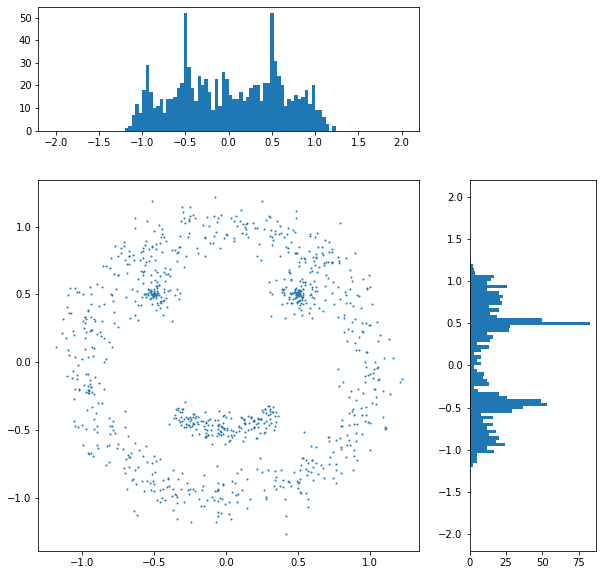

In [75]:
# Question 1
import scipy.stats


def c(x0=0, y0=0, r=1, dr=0.1, t1=0, t2=2 * np.pi):
    r = np.random.normal(r, dr)
    t = np.random.uniform(t1, t2)
    return x0 + r * np.cos(t), y0 + r * np.sin(t)


fs = [
    c,
    functools.partial(c, r=0, dr=0.1, x0=-0.5, y0=0.5),
    functools.partial(c, r=0, dr=0.1, x0=0.5, y0=0.5),
    functools.partial(c, r=0.5, dr=0.05, t1=5 * np.pi / 4, t2=7 * np.pi / 4),
]
a = 4
p = [0.6, 0.1, 0.1, 0.2]


def rxy(fs, a, p):
    return fs[np.random.choice(a=a, p=p)]()


xs, ys = np.column_stack(np.array([rxy(fs, a, p) for _ in range(1000)]))
fig4, ((ax1, ax2), (ax3, ax4)) =\
    plt.subplots(
        nrows=2,
        ncols=2,
        gridspec_kw=dict(width_ratios=[3, 1], height_ratios=[1, 3]),
        figsize=(10, 10)
    )
fig4.delaxes(ax2)
b = np.linspace(-2, 2, 101)
ax3.scatter(xs, ys, s=1)
ax1.hist(xs, bins=b)
ax4.hist(ys, bins=b, orientation='horizontal')
plt.show()

/tmp/ipykernel_32777/2636749302.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot(b, 2 / np.sqrt(1 - 4 * b))


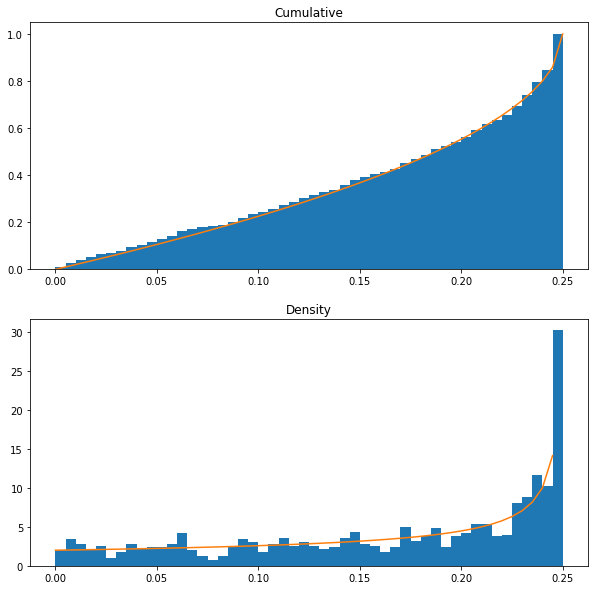

In [76]:
# Question 2

def rx():
    u = np.random.random()
    return u * (1 - u)


d = [rx() for _ in range(1000)]
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
b = np.linspace(0, 0.25, 51)
ax1.hist(d, bins=b, cumulative=True, density=True)
ax1.plot(b, 1 - np.sqrt(1 - 4 * b))
ax1.set_title("Cumulative")
ax2.hist(d, bins=b, density=True)
ax2.plot(b, 2 / np.sqrt(1 - 4 * b))
ax2.set_title("Density")
plt.show()

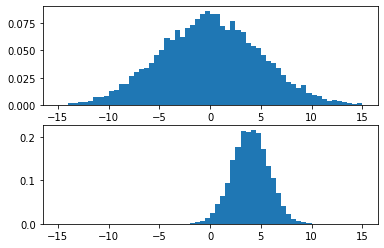

In [77]:
# Question 6
num_samp = 10000
normal = scipy.stats.norm
cauchy = scipy.stats.cauchy
xs = [4.3, 2.8, 3.9, 4.1, 9, 4.5, 3.3]
prior = [np.random.normal(0, 5) for _ in range(num_samp)]


def pr(mu):
    return np.prod(0.99 * normal.pdf(xs, loc=mu, scale=5) + 0.01 * cauchy.pdf(xs))


posterior = list(map(pr, prior))
fig6, (ax61, ax62) = plt.subplots(2, 1)
b = np.linspace(-15, 15, 61)
ax61.hist(prior, bins=b, density=True)
ax62.hist(prior, bins=b, density=True, weights=posterior)
plt.show()

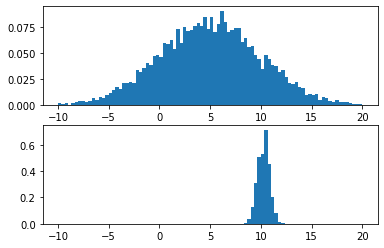

In [78]:
# Question 8 (d)
num_samp = 10000
xbar = 10.3
n = 30
y = 8.8
SICK = 1
HEALTHY = 0


def rvh():
    return HEALTHY if np.random.random() < 0.99 else SICK


def rvm():
    return scipy.stats.norm.rvs(loc=5, scale=5)


def pr(h, m):
    if h == SICK:
        a = 99 ** 2 / np.sqrt(2 * np.pi * 2.1 ** 2) * np.e ** (-y ** 2 / (2 * 2.1) ** 2)
    else:
        a = 1 / np.sqrt(2 * np.pi * 3.2 ** 2) * np.e ** (-(y - m) ** 2 / (2 * 3.2) ** 2)
    return np.e ** (-n / (2 * 3.2 ** 2) * (m ** 2 - 2 * m * xbar)) - (m - 5) ** 2 / 18 * a


rvs = [(rvh(), rvm()) for _ in range(num_samp)]
rvhs, rvms = np.column_stack(rvs)
ps = list(map(lambda x: pr(*x), rvs))
fig8, (ax81, ax82) = plt.subplots(2, 1)
bx = np.linspace(0, 1, 3)
by = np.linspace(-10, 20, 91)
ax81.hist(rvms, bins=by, density=True)
ax82.hist(rvms, bins=by, density=True, weights=ps)
plt.show()

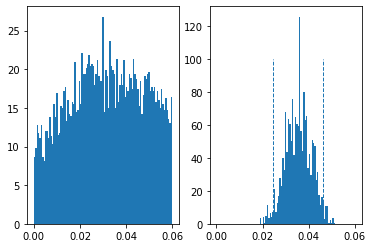

In [88]:
# Question 9
samp_size = 10000
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
climate = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)].copy()
climate['t'] = climate.yyyy + (climate.mm-1)/12
climate['temp'] = (climate.tmin + climate.tmax)/2

def rva():
    return scipy.stats.norm.rvs(loc=-60.458, scale=10)

def rvb1():
    return scipy.stats.norm.rvs(loc=-1.069, scale=5)

def rvb2():
    return scipy.stats.norm.rvs(loc=-6.5452, scale=5)

def rvg():
    return scipy.stats.norm.rvs(loc=0.0355, scale=0.03)

def lgp(a, b1, b2, g):
    t = climate['t']
    temp = climate['temp']
    m = a + b1 * np.sin(2 * np.pi * t) * b2 * np.cos(2 * np.pi * t) + g * t
    ps = scipy.stats.norm.pdf(temp, loc=m, scale=100)
    return np.sum(np.log(ps))

rvs = [(rva(), rvb1(), rvb2(), rvg()) for _ in range(samp_size)]
_, _, _, gs = np.column_stack(rvs)
ps = list(map(lambda x: lgp(*x), rvs))
ps = np.e ** (ps - max(ps))
ps = ps / np.sum(ps)
i = np.argsort(gs)
ps, gs = ps[i], gs[i]
f = np.cumsum(ps)
lo, hi = gs[f < 0.025][-1], gs[f > 0.975][0]
fig10, (ax91, ax92) = plt.subplots(1, 2)
bs = np.linspace(0, 0.06, 100)
ax91.hist(gs, bins=bs, density=True)
ax92.hist(gs, bins=bs, density=True, weights=ps)
ax92.add_line(Line2D([lo, lo], [0, 100], linewidth=1, linestyle='--'))
ax92.add_line(Line2D([hi, hi], [0, 100], linewidth=1, linestyle='--'))
plt.show()